In [37]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from pyspark.sql.types import IntegerType
from pyspark.sql import Row


INPUT_PATH = "hdfs://BigDataHA/user/s277309/recsys_data/"
TEST = False

features = [
    # Tweet features
    "text_tokens",      # List[long]    Ordered list of Bert ids corresponding to Bert tokenization of Tweet text
    "hashtags",         # List[string]  Tab separated list of hastags (identifiers) present in the tweet
    "tweet_id",         # String        Tweet identifier (unique)
    "present_media",    # List[String]  Tab separated list of media types. Media type can be in (Photo, Video, Gif)
    "present_links",    # List[string]  Tab separated list of links (identifiers) included in the Tweet
    "present_domains",  # List[string]  Tab separated list of domains included in the Tweet (twitter.com, dogs.com)
    "tweet_type",       # String        Tweet type, can be either Retweet, Quote, Reply, or Toplevel
    "language",         # String        Identifier corresponding to the inferred language of the Tweet
    "tweet_timestamp",  # Long          Unix timestamp, in sec of the creation time of the Tweet
    
    # Engaged-with User (i.e., Engagee) Features
    "engaged_with_user_id",                 # String    User identifier
    "engaged_with_user_follower_count",     # Long      Number of followers of the user
    "engaged_with_user_following_count",    # Long      Number of accounts the user is following
    "engaged_with_user_is_verified",        # Bool      Is the account verified?
    "engaged_with_user_account_creation",   # Long      Unix timestamp, in seconds, of the creation time of the account
    
    # Engaging User (i.e., Engager) Features
    "engaging_user_id",                     # String    User identifier   
    "engaging_user_follower_count",         # Long      Number of followers of the user
    "engaging_user_following_count",        # Long      Number of accounts the user is following
    "engaging_user_is_verified",            # Bool      Is the account verified?
    "engaging_user_account_creation",       # Long      Unix timestamp, in seconds, of the creation time of the account
    
    # Engagement features
    "engagee_follows_engager"   # Bool  Engagee follows engager?
]

features_idx = dict(zip(features, range(len(features))))

labels_idx = {
    # Engagement features (cont.)
    "reply_timestamp": 20,                  # Long      Unix timestamp (in seconds) of one of the replies, if there is at least one
    "retweet_timestamp": 21,                # Long      Unix timestamp (in seconds) of the retweet by the engaging user, if there is at least one
    "retweet_with_comment_timestamp": 22,   # Long      Unix timestamp (in seconds) of one of the retweet with comment by the engaging user, if there is at least one
    "like_timestamp": 23                    # Long      Unix timestamp (in seconds) of the like by the engaging user, if they liked the tweet
}

labels = ["TARGET_" + l for l in labels_idx.keys()]

# Dataset

In [41]:
if TEST:
    INPUT_PATH = "recsys_data_sample_generated/sample_0.0003"
    df = spark.read.parquet(INPUT_PATH)
else:
    schema = features + list(map(lambda l: f"TARGET_{l}", labels_idx))  # Column names
    df = sc.textFile(INPUT_PATH).map(lambda line: line.strip().split("\x01")).toDF(schema)

In [42]:
def binarize_label(el):
    if el != '':
        return 1
    return 0

binarize = spark.udf.register("binary", binarize_label, IntegerType())

# Documentation suggests not to use withColumn in a for loop.
# But it is not clear how to add multiple columns with a single call
binary_labels = []
for l in labels:
    bin_l = "binary_" + l
    df = df.withColumn(bin_l, binarize(df[l]))
    binary_labels.append(bin_l)

# EDA
Compute conditioned probability of a label being equal to 1, conditioning on one or more attributes

In [54]:
def conditional_prob(df, conditioning_rv, target):
    """
    Estimate and plot conditional probability of a target being True, given a set of conditioning random variables.
    This function is not suitable if we have attributes of type List[string], e.g. hashtags
    
    Args:
        df (DataFrame): pyspark DataFrame with random variables sample realizations
        conditioning_rv (List[str]): names of the conditioning random_variables
        target: target random variable for hìwhich parameter is being estimated
        
    Return:
        result: dataframe column with conditioned probability value for each sample
    """
    
    # For fields like hashtags, of type List[str] -> unwind the list and create a record for each value in the list
    def unwindField(row, field_name):
        dict_row = row.asDict()
        field = dict_row.pop(field_name, None)
        
        rows = []
        if field: # If not empty
            for el in field.split('\t'):
                dict_row[field_name] = el
                rows.append(Row(**dict_row))

        else:
            dict_row[field_name] = 'None' # Instead of str('')
            rows.append(Row(**dict_row))

        return rows
    
    targets_dict = {
        'binary_TARGET_reply_timestamp': 'reply',
        'binary_TARGET_retweet_timestamp': 'retweet',
        'binary_TARGET_retweet_with_comment_timestamp': 'retweet_comment',
        'binary_TARGET_like_timestamp': 'like'
    }
    

    # Be careful, of course it can be very expensive, especially in terms of memory
    for field in conditioning_rv:
        if field in ["text_tokens", "hashtags", "present_media", "present_links", "present_domains"]:
            df = df.rdd.flatMap(lambda row: unwindField(row, field)).toDF()
    
    # Better not to condition on a group but single RV
    group = ', '.join(conditioning_rv)
    target_table_name = targets_dict[target]
    
    result = df.groupBy(conditioning_rv).\
        agg({f"{target}":"mean", "*":"count"}).\
        withColumnRenamed(f"avg({target})", f"conditional_probability_{target_table_name}").\
        withColumnRenamed("count(1)", "num_samples")
    
    plotDF = result.groupBy('conditional_probability_{}'.format(target_table_name)).\
    agg({'num_samples': 'sum'}).\
    withColumnRenamed("sum(num_samples)", "num_samples")
    
    # WARNING: Memory issues? If possible find alternative
    pdDF = plotDF.toPandas().sort_values("conditional_probability_{}".format(target_table_name))
    
    fig, ax = plt.subplots()
    ax.plot(pdDF["conditional_probability_{}".format(target_table_name)],
            pdDF["num_samples"], marker = 'o')
    
    ax.set_ylim(bottom=0)
    ax.set_ylabel("Samples per mean target value")
    ax.set_xlabel("Mean target values")
    ax.set_title(target_table_name)
    
    plt.show()
    
    # Other plots?
                                                                                        
    return result

## Example use: toy dataset

In [50]:
toy_df = df.limit(1000)

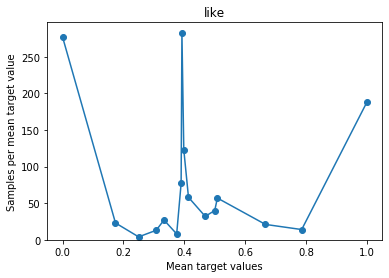

In [58]:
# Better to have a single random variable to test significance
# To group on more than one field, simply reapply this function
result = conditional_prob(toy_df, ["hashtags", "language"], "binary_TARGET_like_timestamp")

In [55]:
result.show(10, truncate = False)

+--------------------------------+----------------------------+-----------+
|hashtags                        |conditional_probability_like|num_samples|
+--------------------------------+----------------------------+-----------+
|080D70D1641C03491307C303817EC52B|1.0                         |1          |
|84D9AF8CAF3A24652636888425F8F858|1.0                         |1          |
|912C7334507FA6B3F2AB06F29654D13C|0.0                         |1          |
|8B4EB30999A611128AC3A7BFAB5D5D54|1.0                         |1          |
|4E449568BF1F066467DFB8F8B8BB260F|0.0                         |1          |
|1F83B2FE3F057B23B9B777A6FCC8BF85|0.0                         |1          |
|8706CAF44FA6E68C87FD6705366F280A|1.0                         |1          |
|245A4C389C12106B8F882F28BE3BADF3|0.0                         |1          |
|29F6EA9C3018D568276BEDD8CDCBBAF3|0.0                         |1          |
|ACD562A8F6A1987AB22CF1007F69821B|0.0                         |1          |
+-----------

## Dataset EDA

In order for conditioning (and target encoding) to be meaningful, we would like to see sparsity of conditional probabilities estimates (e.g. see hashtags estimates: that is an example of not meaningful target encoding).

### Hashtags

Result is meaningless for 'hashtags' alone: on average we have ~0.4 probability, which is very close to the probability of having 'like' = 1 unconditioned.

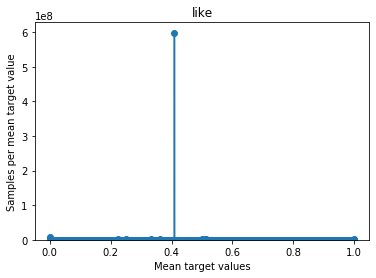

CPU times: user 991 ms, sys: 289 ms, total: 1.28 s
Wall time: 3min 28s


In [56]:
%%time
# Better to have a single random variable to test significance
# To group on more than one field, simply reapply this function
result = conditional_prob(df, ["hashtags"], "binary_TARGET_like_timestamp")

### Hashtags, Language

Results become meaningful if we condition on more than one field.

How do we handle estimates supported by very low number of counts?

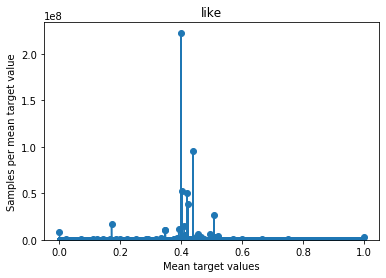

In [60]:
%%time
# Better to have a single random variable to test significance
# To group on more than one field, simply reapply this function
result = conditional_prob(df, ["hashtags", "language"], "binary_TARGET_like_timestamp")